# QM Data Analysis

## Data explanation

Data wrangling of cycling trip data from the [TfL Unified API](https://cycling.data.tfl.gov.uk/).
Count locations and trip count data for 2022.

### Converting Data into Pandas and Geopandas

The data for the locations are fetched from the [TfL Unified API](https://cycling.data.tfl.gov.uk/) and saved as a Geopandas Geodataframe.   
Please save the following files from the TfL website under the folder `Data/ActiveTravelCounts`.
- 0-Count locations.csv
- 2022-Central.csv
- 2022-Inner-Part1.csv
- 2022-Inner-Part2.csv
- 2022-Outer.csv

Note that all data in the Data subdirectory is ignored in the `.gitignore` file.

#### File names

The file names that are created through this script is as follows.

|Data|File name|df/gdf name|
|:---|:---|:---|
|Points|`count_locations.geoparquet`|`loc_gdf`|
|Trips|`travel_counts.parquet`|`counts_df`|

For your own analysis, use the `pd.read_parquet()` or `gpd.read_parquet()` function to read the parquet files. It should be cleaned up enough!


In [1]:
# import libraries

import os
from urllib.request import urlopen
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# data source
# https://cycling.data.tfl.gov.uk/

# files saved under Data/ActiveTravelCounts
dir = 'Data/ActiveTravelCounts'
# raw files
loc_raw = '0-Count locations.csv'
central_raw = '2022-Central.csv'
inner_raw1 = '2022-Inner-Part1.csv'
inner_raw2 = '2022-Inner-Part2.csv'
outer_raw = '2022-Outer.csv'
# saved file name
location_fn = 'count_locations.geoparquet'
travelcounts_fn = 'travel_counts.parquet'

# geodataframe for points data will be saved as loc_gdf
# dataframe for counts will be saved as counts_df

# load the points data

# check if gpkg file already exists
# if not, convert the raw file into geoparquet after reading it in
if not os.path.exists(os.path.join(dir, location_fn)):
    print("Loading locations from csv and saving as geoparquet")
    loc_df = pd.read_csv(os.path.join(dir, loc_raw))
    loc_gdf = gpd.GeoDataFrame(loc_df, geometry = gpd.points_from_xy(loc_df['Easting (UK Grid)'], loc_df['Northing (UK Grid)'], crs = 'EPSG:27700'))
    # convert Functional area for monitoring into category
    loc_gdf['Functional area for monitoring'] = loc_gdf['Functional area for monitoring'].astype('category')
    loc_gdf.to_parquet(os.path.join(dir, location_fn))

# if file already there, load from gpkg
else:
    print("Loading locations from processed geoparquet")
    loc_gdf = gpd.read_parquet(os.path.join(dir, location_fn))

print("Location load complete. Use loc_gdf")

# load the travel counts data
# check if file already exists
# if not, load from csv and save the chunk before analysis

if not os.path.exists(os.path.join(dir, travelcounts_fn)):
    print("Loading counts from CSV and cleaning data")

    # load files
    cen_df = pd.read_csv(os.path.join(dir, central_raw))
    in1_df = pd.read_csv(os.path.join(dir, inner_raw1))
    in2_df = pd.read_csv(os.path.join(dir, inner_raw2))
    out_df = pd.read_csv(os.path.join(dir, outer_raw))

    # add zone
    cen_df.insert(2, 'Zone', 'Central')
    in1_df.insert(2, 'Zone', 'Inner')
    in2_df.insert(2, 'Zone', 'Inner')
    out_df.insert(2, 'Zone', 'Outer')

    # join data frames
    counts_df = pd.concat([cen_df, in1_df, in2_df, out_df])

    # clean data
    # insert datetime column in datetime format
    counts_df.insert(3, 'datetime', pd.to_datetime(counts_df['Date'] + ' ' + counts_df['Time'], dayfirst = True))
    
    # turn into categorical data
    categorical = ['Zone', 'Weather', 'Day', 'Round', 'Dir', 'Path', 'Mode']
    
    for c in categorical:
        counts_df[c] = counts_df[c].astype('category')

    # save parquet file
    counts_df.to_parquet(os.path.join(dir, travelcounts_fn))

# if file already there, load from parquet
else:
    print("Loading counts from processed parquet")
    counts_df = pd.read_parquet(os.path.join(dir, travelcounts_fn))

print("Counts load complete. Use counts_df")

Loading locations from processed geoparquet
Location load complete. Use loc_gdf
Loading counts from processed parquet
Counts load complete. Use counts_df


### Looking at the `loc_gdf` Geodataframe

Check to confirm file loading is done correctly.


In [2]:
loc_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2297 entries, 0 to 2296
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Site ID                            2297 non-null   object  
 1   Which folder?                      2297 non-null   object  
 2   Shared sites                       2297 non-null   object  
 3   Location description               2297 non-null   object  
 4   Borough                            2297 non-null   object  
 5   Functional area for monitoring     2297 non-null   category
 6   Road type                          2297 non-null   object  
 7   Is it on the strategic CIO panel?  2297 non-null   int64   
 8   Easting (UK Grid)                  2297 non-null   float64 
 9   Northing (UK Grid)                 2297 non-null   float64 
 10  Latitude                           2297 non-null   float64 
 11  Longitude                          

<Axes: >

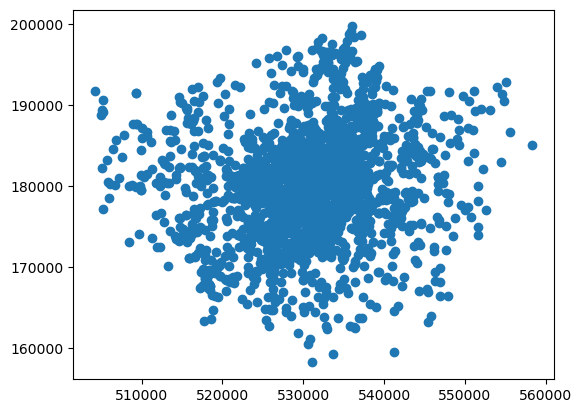

In [3]:
loc_gdf.plot()

In [4]:
loc_gdf.sample(5, random_state = 42)

,Site ID,Which folder?,Shared sites,Location description,Borough,Functional area for monitoring,Road type,Is it on the strategic CIO panel?,Easting (UK Grid),Northing (UK Grid),Latitude,Longitude,geometry
426,G07,Cycleway counts,0,Craven Road jw Gloucester Terrace (B road),Westminster,Inner,0,0,526481.000,181015.000,51.513910,-0.178664,POINT (526481.000 181015.000)
1292,MHPCY036,Cycleway counts,0,Ruckhold Road (south),Waltham Forest,Outer,A Road,0,537677.170,185999.810,51.556082,-0.015470,POINT (537677.170 185999.810)
208,CENCY701,Strategic counts,0,Regent Street,Westminster,Central,A Road,1,529632.840,180463.330,51.508236,-0.133483,POINT (529632.840 180463.330)
1882,OUTCY427,Strategic counts,QWPCY169,Grand Union Canal (Hayes & Harlington),Hillingdon,Outer,MVF,1,509969.137,179490.991,51.503656,-0.416990,POINT (509969.137 179490.991)
282,CGRCY040,Cycleway counts,CENCY139,The Mall,Westminster,Central,Local Street,0,529385.070,179898.720,51.503215,-0.137247,POINT (529385.070 179898.720)


### Looking at the `counts_df` dataframe

In [5]:
counts_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2211584 entries, 0 to 709887
Data columns (total 13 columns):
 #   Column    Dtype         
---  ------    -----         
 0   Year      int64         
 1   UnqID     object        
 2   Zone      category      
 3   datetime  datetime64[ns]
 4   Date      object        
 5   Weather   category      
 6   Time      object        
 7   Day       category      
 8   Round     category      
 9   Dir       category      
 10  Path      category      
 11  Mode      category      
 12  Count     int64         
dtypes: category(7), datetime64[ns](1), int64(2), object(3)
memory usage: 132.9+ MB


In [6]:
counts_df.sample(5, random_state = 42)

,Year,UnqID,Zone,datetime,Date,Weather,Time,Day,Round,Dir,Path,Mode,Count
823905,2022,INNCY510,Inner,2022-06-30 14:15:00,30/06/2022,Dry,14:15:00,Weekday,A,Southbound,Carriageway,Pedestrians,0
322451,2022,OUTCY184,Outer,2022-06-07 10:45:00,07/06/2022,Dry,10:45:00,Weekday,A,Southbound,Pavement - Northbound,E-scooters,0
832707,2022,INNCY516,Inner,2022-07-19 06:45:00,19/07/2022,Dry,06:45:00,Weekday,A,Eastbound,Carriageway,Conventional cycles,0
82294,2022,INNCY042,Inner,2022-06-30 19:30:00,30/06/2022,Wet,19:30:00,Weekday,A,Eastbound,Pavement - Eastbound,Conventional cycles,0
6384,2022,INNCY003,Inner,2022-05-18 18:00:00,18/05/2022,Dry,18:00:00,Weekday,A,Northbound,Pavement - Northbound,Pedestrians,47


In [8]:
# Delete the row with "Pedestrians" in the Mode column
counts_df = counts_df[counts_df['Mode'] != 'Pedestrians']

# Use the str.split method to split the values of the Path column and take the first part after segmentation
counts_df['Path'] = counts_df['Path'].str.split('-').str[0].str.strip()

# Add a new column of isdry and map it to dry: 1 and wet: 0 based on the value of the Weather column
counts_df['isdry'] = counts_df['Weather'].map({'Dry': 1, 'Wet': 0})

# Peak Time - Monday to Friday (not on public holidays) between 06:30 and 09:30, and between 16:00 and 19:00
# According to https://tfl.gov.uk/fares/find-fares/tube-and-rail-fares
# Time -> datetime
counts_df['Time'] = pd.to_datetime(counts_df['Time'], format='%H:%M:%S').dt.time

# define is peak time?
def is_peak(time):
    peak_periods = [(pd.Timestamp('06:30:00').time(), pd.Timestamp('09:30:00').time()),
                    (pd.Timestamp('16:00:00').time(), pd.Timestamp('19:00:00').time())]

    for start, end in peak_periods:
        if start <= time <= end:
            return 1  # peak time is 1
    return 0  # off-peak time is 0

# add ispeak column
counts_df['ispeak'] = counts_df['Time'].apply(lambda x: is_peak(x))

In [9]:
# Add a new column isCarriageway, mapping it to 1 or 0 based on the value of the Path column
counts_df['isCarriageway'] = counts_df['Path'].apply(lambda x: 1 if x == 'Carriageway' else 0)

# Add a new column isPavement, mapping it to 1 or 0 based on the value of the Path column
counts_df['isPavement'] = counts_df['Path'].apply(lambda x: 1 if x == 'Pavement' else 0)

# Add a new column isCycle, mapping it to 1 or 0 based on the value of the Path column
counts_df['isCycle'] = counts_df['Path'].apply(lambda x: 1 if x == 'Cycle lane' else 0)

# Add a new column isBus, mapping it to 1 or 0 based on the value of the Path column
counts_df['isBus'] = counts_df['Path'].apply(lambda x: 1 if x == 'Bus lane' else 0)

# Add a new column isShared, mapping it to 1 or 0 based on the value of the Path column
counts_df['isShared'] = counts_df['Path'].apply(lambda x: 1 if x == 'Shared path' else 0)

In [12]:
counts_df.sample(5, random_state = 42)

,Year,UnqID,Zone,datetime,Date,Weather,Time,Day,Round,Dir,Path,Mode,Count,isdry,ispeak,isCarriageway,isPavement,isCycle,isBus,isShared
727824,2022,INNCY448,Inner,2022-06-07 10:00:00,07/06/2022,Dry,10:00:00,Weekday,A,Northbound,Carriageway,E-scooters,0,1,0,1,0,0,0,0
536654,2022,OUTCY323,Outer,2022-07-05 09:30:00,05/07/2022,Dry,09:30:00,Weekday,A,Southbound,Pavement,Conventional cycles,0,1,1,0,1,0,0,0
32161,2022,CSHCY028,Inner,2022-05-18 14:15:00,18/05/2022,Dry,14:15:00,Weekday,A,Westbound,Carriageway,E-scooters,2,1,0,1,0,0,0,0
747690,2022,INNCY461,Inner,2022-04-28 16:30:00,28/04/2022,Dry,16:30:00,Weekday,A,Northbound,Carriageway,Cargo bikes,0,1,1,1,0,0,0,0
756784,2022,INNCY466,Inner,2022-06-15 18:00:00,15/06/2022,Dry,18:00:00,Weekday,A,Southbound,Pavement,E-scooters,0,1,1,0,1,0,0,0


In [13]:
new_df = pd.DataFrame()

# Add columns that need to be classified
new_df['Date'] = counts_df['Date']
new_df['Weather'] = counts_df['Weather']
new_df['Time'] = counts_df['Time']
new_df['Path'] = counts_df['Path']
new_df['Mode'] = counts_df['Mode']

# Calculate the sum of each group and add it to the new column 'TotalCounts'
new_df['TotalCounts'] = counts_df.groupby(['Date', 'Weather', 'Time', 'Path', 'Mode'])['Count'].transform('sum')

# Remove duplicates to obtain unique combinations
new_df = new_df.drop_duplicates(subset=['Date', 'Weather', 'Time', 'Path', 'Mode', 'TotalCounts'])

print(new_df)


/tmp/ipykernel_5434/1565916047.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  new_df['TotalCounts'] = counts_df.groupby(['Date', 'Weather', 'Time', 'Path', 'Mode'])['Count'].transform('sum')


              Date Weather      Time         Path         Mode  TotalCounts
0       13/07/2022     Dry  06:00:00  Carriageway  Cargo bikes            0
1       13/07/2022     Dry  06:15:00  Carriageway  Cargo bikes            1
2       13/07/2022     Dry  06:30:00  Carriageway  Cargo bikes            0
3       13/07/2022     Dry  06:45:00  Carriageway  Cargo bikes            0
4       13/07/2022     Dry  07:00:00  Carriageway  Cargo bikes            0
...            ...     ...       ...          ...          ...          ...
664955  27/06/2022     Dry  20:45:00   Cycle lane   E-scooters            0
664956  27/06/2022     Dry  21:00:00   Cycle lane   E-scooters            0
664957  27/06/2022     Dry  21:15:00   Cycle lane   E-scooters            0
664958  27/06/2022     Dry  21:30:00   Cycle lane   E-scooters            1
664959  27/06/2022     Dry  21:45:00   Cycle lane   E-scooters            0

[37720 rows x 6 columns]


In [15]:
new_df.sample(5, random_state = 42)

,Date,Weather,Time,Path,Mode,TotalCounts
138155,25/05/2022,Wet,16:45:00,Carriageway,E-scooters,4
114796,04/05/2022,Wet,17:00:00,Pavement,Conventional cycles,17
597,13/07/2022,Dry,11:15:00,Cycle lane,Conventional cycles,326
856366,30/06/2022,Dry,17:30:00,Shared path,E-scooters,4
67421,15/06/2022,Dry,13:15:00,Cycle lane,Conventional cycles,166


<Axes: xlabel='Mode', ylabel='Count'>

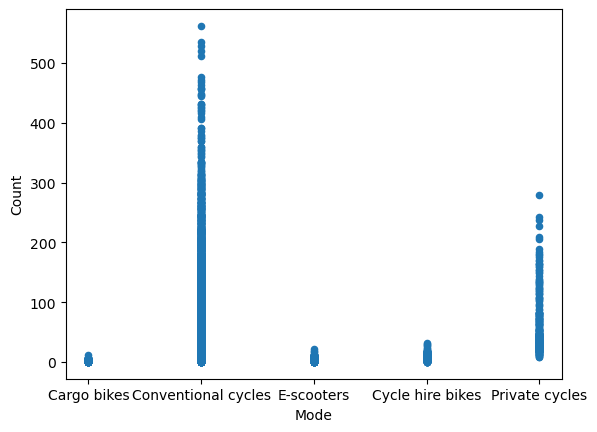

In [9]:
counts_df.plot.scatter('Mode', 'Count')

<Axes: xlabel='Time'>

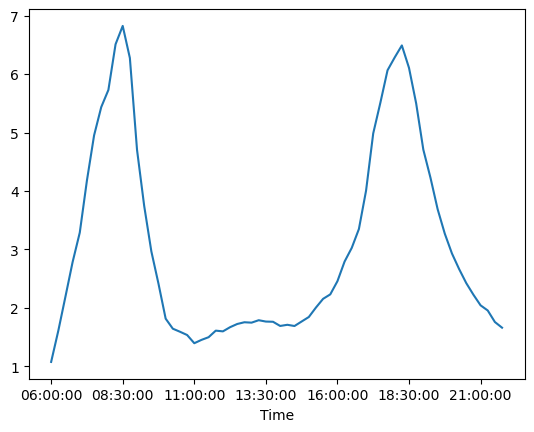

In [10]:
counts_df[counts_df.Mode == 'Conventional cycles'].groupby(['Time']).Count.mean().plot.line()

/tmp/ipykernel_148/939877937.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for label, df in counts_df.groupby(['Weather']):


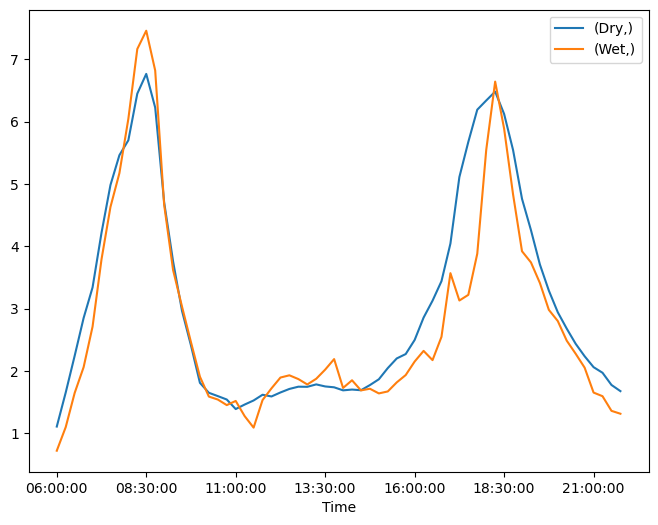

In [11]:
fig, ax = plt.subplots(figsize = (8, 6))
for label, df in counts_df.groupby(['Weather']):
    df[df.Mode == 'Conventional cycles'].groupby(['Time']).Count.mean().plot.line(ax = ax, label = label)
plt.legend()